In [21]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from tqdm import tqdm

In [2]:
ds_cfd = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_cfd.nc")
ds_fd = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_fd.nc")
ds_csu = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_csu.nc")
ds_id = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_id.nc")
ds_su = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_su.nc")

ds_cdd = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_cdd.nc")
ds_cwd = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_cwd.nc")
ds_pd = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_pd.nc")
ds_rr1 = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_rr1.nc")
ds_rx1day = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_rx1day.nc")
ds_rx5day = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_rx5day.nc")
ds_sdii = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_sdii.nc")

In [3]:
lons, lats = np.meshgrid(ds_cfd.lon, ds_cfd.lat)

In [4]:
ds_spruce = xr.open_dataset('../../data/sweden/mescan-surfex_spruce.nc')

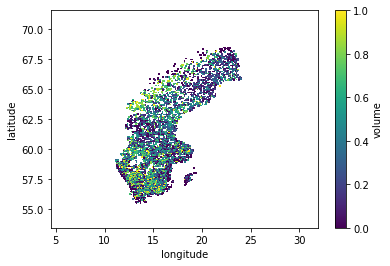

In [5]:
ds_spruce.volume.plot()

In [6]:
data = {
    'ratio': ds_spruce.volume.values.ravel()
}

In [7]:
data["cfd"] = ds_cfd.number_of_cfd_periods_with_more_than_5days_per_time_period.values.ravel()
data["fd"] = ds_fd.frost_days_index_per_time_period.values.ravel()
data["csu"] = ds_csu.number_of_csu_periods_with_more_than_5days_per_time_period.values.ravel()
data["id"] = ds_id.ice_days_index_per_time_period.values.ravel()
data["su"] = ds_su.summer_days_index_per_time_period.values.ravel()

In [8]:
data["cdd"] = ds_cdd.number_of_cdd_periods_with_more_than_5days_per_time_period.values.ravel()
data["cwd"] = ds_cwd.number_of_cwd_periods_with_more_than_5days_per_time_period.values.ravel()
data["pd"] = ds_pd.precipitation_days_index_per_time_period.values.ravel()
data["rr1"] = ds_rr1.wet_days_index_per_time_period.values.ravel()
data["rx1day"] = ds_rx1day.highest_one_day_precipitation_amount_per_time_period.values.ravel()
data["rx5day"] = ds_rx5day.highest_five_day_precipitation_amount_per_time_period.values.ravel()
data["sdii"] = ds_sdii.simple_daily_intensity_index_per_time_period.values.ravel()

In [9]:
df = pd.DataFrame(data)

In [10]:
df.dropna(inplace=True)

In [11]:
df['predominant'] = np.where(df['ratio'] > 0.5, 1, 0)

In [12]:
df.head()

,ratio,cfd,fd,csu,id,su,cdd,cwd,pd,rr1,rx1day,rx5day,sdii,predominant
20610,0.0,62.0,1469.0,9.0,735.0,245.0,210.0,21.0,1314.0,1314.0,64.932266,64.932266,4.627773,0
20611,0.0,63.0,1471.0,7.0,749.0,209.0,200.0,20.0,1304.0,1304.0,63.609093,63.609093,4.704560,0
20618,0.0,64.0,1504.0,10.0,781.0,250.0,200.0,21.0,1723.0,1723.0,56.352997,56.352997,4.631788,0
20941,0.0,63.0,1480.0,10.0,767.0,226.0,181.0,22.0,1229.0,1229.0,62.699570,62.699570,4.897202,0
20942,0.0,65.0,1500.0,9.0,780.0,219.0,177.0,19.0,1188.0,1188.0,62.144646,62.144646,4.987121,0


In [13]:
df.columns[1:-1]

Index(['cfd', 'fd', 'csu', 'id', 'su', 'cdd', 'cwd', 'pd', 'rr1', 'rx1day',
       'rx5day', 'sdii'],
      dtype='object')

In [14]:
X = df[df.columns[1:-1]]

In [15]:
y = df['predominant']

In [16]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [18]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15)

In [19]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
y_pred = rf.predict(X_test)

In [21]:
precision_score(y_test, y_pred)

0.7180616740088106

In [22]:
accuracy_score(y_test, y_pred)

0.7387802071346375

In [22]:
recall_score(y_test, y_pred)

0.7502876869965478

In [23]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[630, 239],
       [217, 652]])

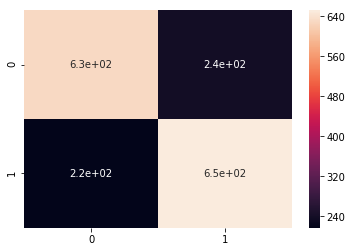

In [24]:
sn.heatmap(cm, annot=True)

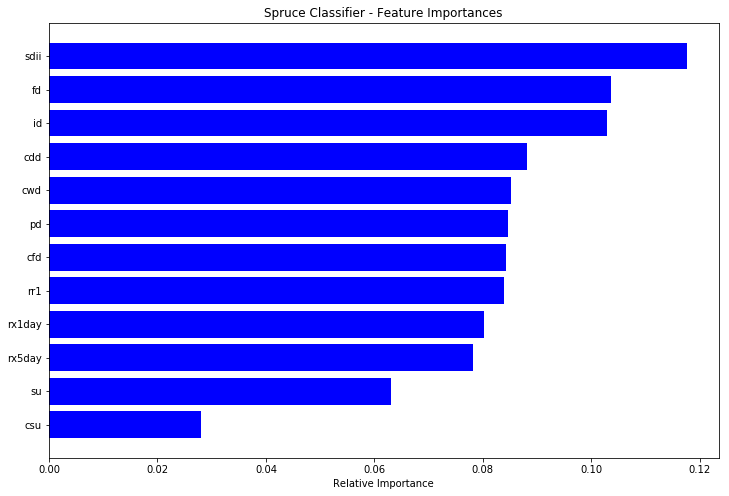

In [25]:
features = [c for c in X.columns]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Spruce Classifier - Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()